In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F 
from torchvision import datasets, transforms
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [5]:
if torch.cuda.is_available() :
    DEVICE = torch.device('cuda')
else :
    DEVICE = torch.device('cpu')
print(DEVICE, torch.cuda.get_device_name(), '\ttorch : ', torch.__version__)

cuda NVIDIA GeForce GTX 1650 	torch :  1.12.0


In [6]:
BATCH_SIZE = 128
EPOCHS = 100

In [9]:
train_dataset = datasets.MNIST(root = '../../data/MNIST', 
                               download=True,
                               train = True, 
                               transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                              shuffle=True,
                              batch_size = BATCH_SIZE)

test_dataset = datasets.MNIST(root = '../../data/MNIST', 
                               download=True,
                               train = False, 
                               transform= transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset,
                              shuffle=False,
                              batch_size = BATCH_SIZE)

In [10]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


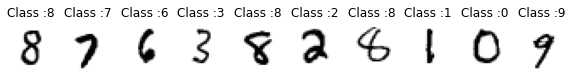

In [12]:
pltsize = 1 
plt.figure(figsize=(pltsize * 10, pltsize))

for i in range(10) :
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap='gray_r')
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [18]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 28*28)
        self.fc3 = nn.Linear(28*28, 10)
        self.batchnorm1 = nn.BatchNorm1d(512)
        self.batchnorm2 = nn.BatchNorm1d(28*28)
        self.droout_prob = 0.5

    def forward(self, x) :
        x = x.reshape(-1, 28*28)
        x = self.fc1(x)
        x = self.batchnorm1(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.droout_prob)
        x = self.fc2(x)
        x = self.batchnorm2(x)
        x = F.relu(x)
        x = F.dropout(x, training = self.training, p = self.droout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim = 1)
        return x

In [33]:
del model

In [34]:
model = Net().to(DEVICE)
import torch.nn.init as init
def weight_init(m) :
    if isinstance(m, nn.Linear) :
        init.kaiming_uniform(m.weight.data)
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.CrossEntropyLoss()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=784, bias=True)
  (fc3): Linear(in_features=784, out_features=10, bias=True)
  (batchnorm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


C:\Users\Admin\AppData\Local\Temp\ipykernel_26580\2100588345.py:5: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(m.weight.data)


In [35]:
def train(model, train_loader, optimizer, log_intervals = 100 ) :
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader) :
        image =  image.to(DEVICE)
        label =  label.to(DEVICE)
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intervals == 0 :
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))


In [36]:
def evaluate(model, test_loader) :
    model.eval()
    correct = 0
    test_loss = 0
    with torch.no_grad() :
        for image, label in test_loader :
            image = image.to(DEVICE) 
            label = label.to(DEVICE)
            output = model(image)
            test_loss = criterion(output, label)
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy = correct * 100 / len(test_loader.dataset)
        return test_loss, test_accuracy

In [37]:
best_accuracy = 0
es = 0 
for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    print('\nEpoch : {}, Test_loss : {:.6f}, Test_accuracy : {:.2f}'.format(
        Epoch, test_loss, test_accuracy
    ))

    if test_accuracy > best_accuracy :
        best_accuracy = test_accuracy
        best_model = best_accuracy
        es = 0
    else :
        es += 1

    if es >= 10 :
        print('최고정확도 : {:.2f}'.format(
            best_accuracy
        ))
        break

Train_Epoch : 1, [0 / 60000](0%)	Train_loss : 3.284930
Train_Epoch : 1, [12800 / 60000](21%)	Train_loss : 0.353508
Train_Epoch : 1, [25600 / 60000](43%)	Train_loss : 0.228744
Train_Epoch : 1, [38400 / 60000](64%)	Train_loss : 0.126869
Train_Epoch : 1, [51200 / 60000](85%)	Train_loss : 0.249427

Epoch : 1, Test_loss : 0.000009, Test_accuracy : 96.65
Train_Epoch : 2, [0 / 60000](0%)	Train_loss : 0.192248
Train_Epoch : 2, [12800 / 60000](21%)	Train_loss : 0.258584
Train_Epoch : 2, [25600 / 60000](43%)	Train_loss : 0.108363
Train_Epoch : 2, [38400 / 60000](64%)	Train_loss : 0.145427
Train_Epoch : 2, [51200 / 60000](85%)	Train_loss : 0.219766

Epoch : 2, Test_loss : 0.000002, Test_accuracy : 97.19
Train_Epoch : 3, [0 / 60000](0%)	Train_loss : 0.332578
Train_Epoch : 3, [12800 / 60000](21%)	Train_loss : 0.114617
Train_Epoch : 3, [25600 / 60000](43%)	Train_loss : 0.125411
Train_Epoch : 3, [38400 / 60000](64%)	Train_loss : 0.180867
Train_Epoch : 3, [51200 / 60000](85%)	Train_loss : 0.127640

Ep

# Fashion MNIST

In [7]:
train_dataset = datasets.FashionMNIST(root = '../../data/FashionMNIST', 
                                      download=True , 
                                      train = True, 
                                      transform= transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_dataset,
                                      batch_size = BATCH_SIZE,
                                      shuffle = True)

test_dataset = datasets.FashionMNIST(root = '../../data/FashionMNIST', 
                                      download=True , 
                                      train = False, 
                                      transform= transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset,
                                      batch_size = BATCH_SIZE,
                                      shuffle = False)

In [9]:
for (X_train, y_train) in train_loader :
    print(X_train.size(), y_train.size())
    print(X_train.type(), y_train.type())
    break

torch.Size([128, 1, 28, 28]) torch.Size([128])
torch.FloatTensor torch.LongTensor


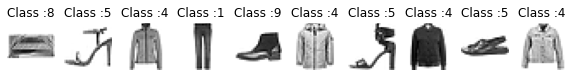

In [10]:
pltsize = 1
plt.figure(figsize = (pltsize * 10 , pltsize))

for i in range(10) :
    plt.subplot(1, 10, i + 1) 
    plt.axis('off')
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28, 28), cmap= 'gray_r')
    plt.title('Class :' + str(y_train[i].item()))
plt.show()

In [91]:
class Net(nn.Module) :
    def __init__(self) :
        super(Net, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            # 마지막에는 ReLU 사용 x!
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
        )

    def forward(self, x) :
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


In [92]:
del model

In [93]:
model = Net().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
criterion = nn.MSELoss()
print(model)

Net(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


In [94]:
def train(model, train_loader, optimizer, log_intevals = 100 ) :
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader) :
        image = image.view(-1, 28 * 28).to(DEVICE)
        target = image.view(-1, 28 * 28).to(DEVICE)
        _, output = model(image)
        optimizer.zero_grad()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % log_intevals == 0 : 
            print('Train_Epoch : {}, [{} / {}]({:.0f}%)\tTrain_loss : {:.6f}'.format(
                Epoch, batch_idx * len(image), len(train_loader.dataset),
                batch_idx * 100 / len(train_loader), loss.item()
            ))


In [95]:
def evlauate(model, test_loader) :
    model.eval()
    test_loss = 0
    encoded_list = []
    decoded_list = []
    with torch.no_grad() :
        for image, _ in test_loader :
            image = image.view(-1, 28 * 28).to(DEVICE)
            target = image.view(-1, 28 * 28).to(DEVICE)
            encoded, output = model(image)
            test_loss = criterion(output, target).item()

        encoded_list.append(image.to('cpu'))
        decoded_list.append(output.to('cpu'))
        test_loss /= len(test_loader.dataset)
        return test_loss, encoded_list, decoded_list

    

Train_Epoch : 1, [0 / 60000](0%)	Train_loss : 0.188651
Train_Epoch : 1, [12800 / 60000](21%)	Train_loss : 0.038212
Train_Epoch : 1, [25600 / 60000](43%)	Train_loss : 0.032873
Train_Epoch : 1, [38400 / 60000](64%)	Train_loss : 0.032205
Train_Epoch : 1, [51200 / 60000](85%)	Train_loss : 0.031103

EPOCH : 1, Test_loss 0.000004



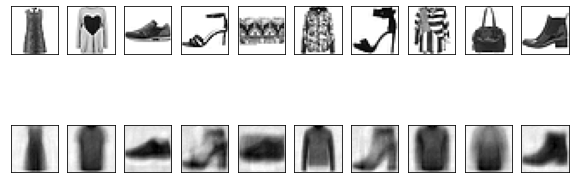

Train_Epoch : 2, [0 / 60000](0%)	Train_loss : 0.026193
Train_Epoch : 2, [12800 / 60000](21%)	Train_loss : 0.025572
Train_Epoch : 2, [25600 / 60000](43%)	Train_loss : 0.027861
Train_Epoch : 2, [38400 / 60000](64%)	Train_loss : 0.025488
Train_Epoch : 2, [51200 / 60000](85%)	Train_loss : 0.026554

EPOCH : 2, Test_loss 0.000003



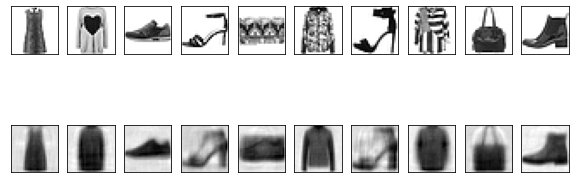

Train_Epoch : 3, [0 / 60000](0%)	Train_loss : 0.023323
Train_Epoch : 3, [12800 / 60000](21%)	Train_loss : 0.025721
Train_Epoch : 3, [25600 / 60000](43%)	Train_loss : 0.025898
Train_Epoch : 3, [38400 / 60000](64%)	Train_loss : 0.024960
Train_Epoch : 3, [51200 / 60000](85%)	Train_loss : 0.023100

EPOCH : 3, Test_loss 0.000003



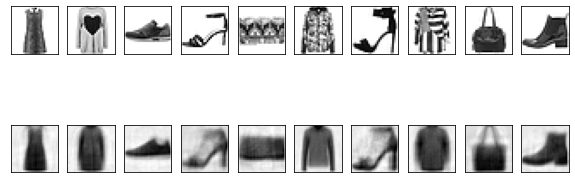

Train_Epoch : 4, [0 / 60000](0%)	Train_loss : 0.023680
Train_Epoch : 4, [12800 / 60000](21%)	Train_loss : 0.026969
Train_Epoch : 4, [25600 / 60000](43%)	Train_loss : 0.023302
Train_Epoch : 4, [38400 / 60000](64%)	Train_loss : 0.025614
Train_Epoch : 4, [51200 / 60000](85%)	Train_loss : 0.022266

EPOCH : 4, Test_loss 0.000003



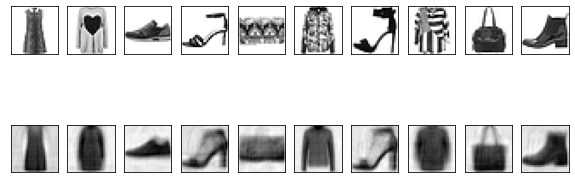

Train_Epoch : 5, [0 / 60000](0%)	Train_loss : 0.024316
Train_Epoch : 5, [12800 / 60000](21%)	Train_loss : 0.022471
Train_Epoch : 5, [25600 / 60000](43%)	Train_loss : 0.024472
Train_Epoch : 5, [38400 / 60000](64%)	Train_loss : 0.024095
Train_Epoch : 5, [51200 / 60000](85%)	Train_loss : 0.025031

EPOCH : 5, Test_loss 0.000003



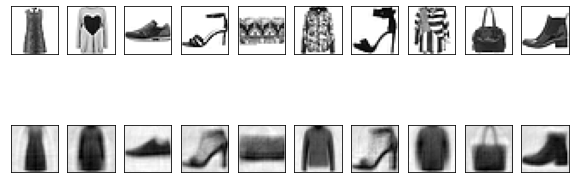

Train_Epoch : 6, [0 / 60000](0%)	Train_loss : 0.023491
Train_Epoch : 6, [12800 / 60000](21%)	Train_loss : 0.024246
Train_Epoch : 6, [25600 / 60000](43%)	Train_loss : 0.022925
Train_Epoch : 6, [38400 / 60000](64%)	Train_loss : 0.023477
Train_Epoch : 6, [51200 / 60000](85%)	Train_loss : 0.025815

EPOCH : 6, Test_loss 0.000003



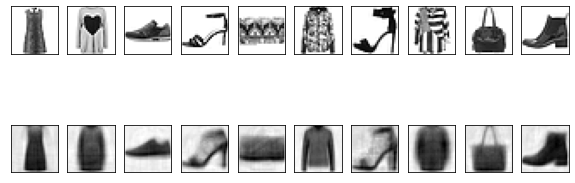

Train_Epoch : 7, [0 / 60000](0%)	Train_loss : 0.023426
Train_Epoch : 7, [12800 / 60000](21%)	Train_loss : 0.022862
Train_Epoch : 7, [25600 / 60000](43%)	Train_loss : 0.021971
Train_Epoch : 7, [38400 / 60000](64%)	Train_loss : 0.023013
Train_Epoch : 7, [51200 / 60000](85%)	Train_loss : 0.020962

EPOCH : 7, Test_loss 0.000003



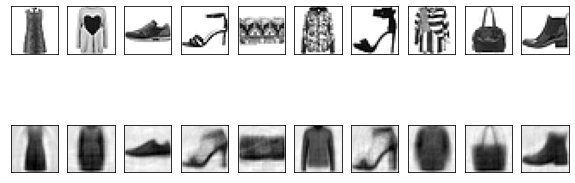

Train_Epoch : 8, [0 / 60000](0%)	Train_loss : 0.022549
Train_Epoch : 8, [12800 / 60000](21%)	Train_loss : 0.021868
Train_Epoch : 8, [25600 / 60000](43%)	Train_loss : 0.024697
Train_Epoch : 8, [38400 / 60000](64%)	Train_loss : 0.025018
Train_Epoch : 8, [51200 / 60000](85%)	Train_loss : 0.022748

EPOCH : 8, Test_loss 0.000003



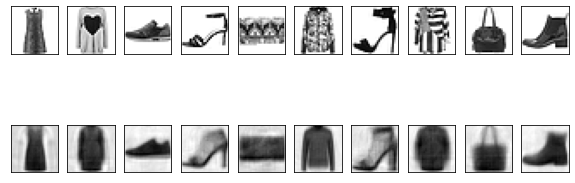

Train_Epoch : 9, [0 / 60000](0%)	Train_loss : 0.023143
Train_Epoch : 9, [12800 / 60000](21%)	Train_loss : 0.023415
Train_Epoch : 9, [25600 / 60000](43%)	Train_loss : 0.021019
Train_Epoch : 9, [38400 / 60000](64%)	Train_loss : 0.022412
Train_Epoch : 9, [51200 / 60000](85%)	Train_loss : 0.021703

EPOCH : 9, Test_loss 0.000003



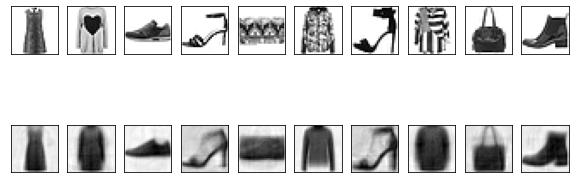

Train_Epoch : 10, [0 / 60000](0%)	Train_loss : 0.021401
Train_Epoch : 10, [12800 / 60000](21%)	Train_loss : 0.022648
Train_Epoch : 10, [25600 / 60000](43%)	Train_loss : 0.025330
Train_Epoch : 10, [38400 / 60000](64%)	Train_loss : 0.022257
Train_Epoch : 10, [51200 / 60000](85%)	Train_loss : 0.022410

EPOCH : 10, Test_loss 0.000003



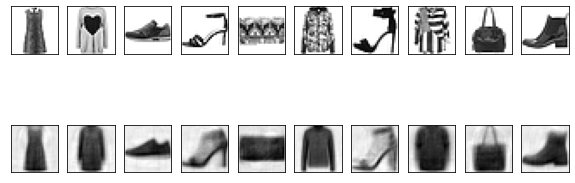

Train_Epoch : 11, [0 / 60000](0%)	Train_loss : 0.022417
Train_Epoch : 11, [12800 / 60000](21%)	Train_loss : 0.022815
Train_Epoch : 11, [25600 / 60000](43%)	Train_loss : 0.022013
Train_Epoch : 11, [38400 / 60000](64%)	Train_loss : 0.022462
Train_Epoch : 11, [51200 / 60000](85%)	Train_loss : 0.023603

EPOCH : 11, Test_loss 0.000003



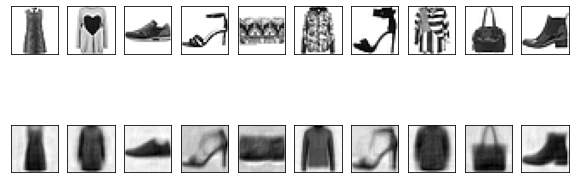

Train_Epoch : 12, [0 / 60000](0%)	Train_loss : 0.021019
Train_Epoch : 12, [12800 / 60000](21%)	Train_loss : 0.021776
Train_Epoch : 12, [25600 / 60000](43%)	Train_loss : 0.023180
Train_Epoch : 12, [38400 / 60000](64%)	Train_loss : 0.022004
Train_Epoch : 12, [51200 / 60000](85%)	Train_loss : 0.022805

EPOCH : 12, Test_loss 0.000003



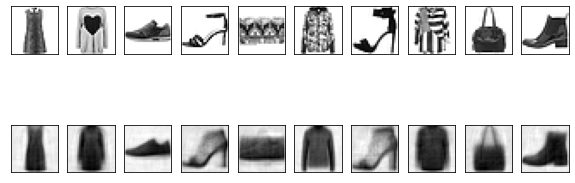

Train_Epoch : 13, [0 / 60000](0%)	Train_loss : 0.024842
Train_Epoch : 13, [12800 / 60000](21%)	Train_loss : 0.023669
Train_Epoch : 13, [25600 / 60000](43%)	Train_loss : 0.023535
Train_Epoch : 13, [38400 / 60000](64%)	Train_loss : 0.020102
Train_Epoch : 13, [51200 / 60000](85%)	Train_loss : 0.025452

EPOCH : 13, Test_loss 0.000003



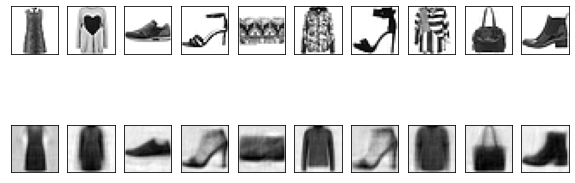

Train_Epoch : 14, [0 / 60000](0%)	Train_loss : 0.022428
Train_Epoch : 14, [12800 / 60000](21%)	Train_loss : 0.023590
Train_Epoch : 14, [25600 / 60000](43%)	Train_loss : 0.024744
Train_Epoch : 14, [38400 / 60000](64%)	Train_loss : 0.023456
Train_Epoch : 14, [51200 / 60000](85%)	Train_loss : 0.023248

EPOCH : 14, Test_loss 0.000003



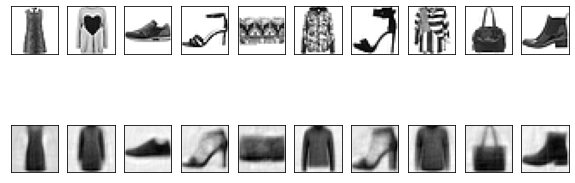

Train_Epoch : 15, [0 / 60000](0%)	Train_loss : 0.022747
Train_Epoch : 15, [12800 / 60000](21%)	Train_loss : 0.023747
Train_Epoch : 15, [25600 / 60000](43%)	Train_loss : 0.022733
Train_Epoch : 15, [38400 / 60000](64%)	Train_loss : 0.023494
Train_Epoch : 15, [51200 / 60000](85%)	Train_loss : 0.023102

EPOCH : 15, Test_loss 0.000003



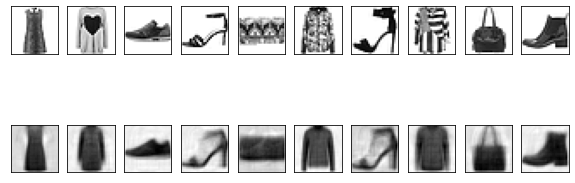

Train_Epoch : 16, [0 / 60000](0%)	Train_loss : 0.022707
Train_Epoch : 16, [12800 / 60000](21%)	Train_loss : 0.022165
Train_Epoch : 16, [25600 / 60000](43%)	Train_loss : 0.021029
Train_Epoch : 16, [38400 / 60000](64%)	Train_loss : 0.023286
Train_Epoch : 16, [51200 / 60000](85%)	Train_loss : 0.020448

EPOCH : 16, Test_loss 0.000003



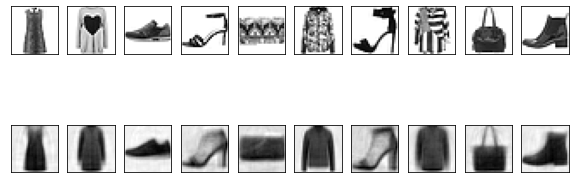

Train_Epoch : 17, [0 / 60000](0%)	Train_loss : 0.021065
Train_Epoch : 17, [12800 / 60000](21%)	Train_loss : 0.022342
Train_Epoch : 17, [25600 / 60000](43%)	Train_loss : 0.022144
Train_Epoch : 17, [38400 / 60000](64%)	Train_loss : 0.021936
Train_Epoch : 17, [51200 / 60000](85%)	Train_loss : 0.022807

EPOCH : 17, Test_loss 0.000003



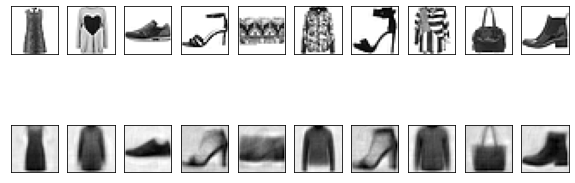

Train_Epoch : 18, [0 / 60000](0%)	Train_loss : 0.022281
Train_Epoch : 18, [12800 / 60000](21%)	Train_loss : 0.020440
Train_Epoch : 18, [25600 / 60000](43%)	Train_loss : 0.024636
Train_Epoch : 18, [38400 / 60000](64%)	Train_loss : 0.024391
Train_Epoch : 18, [51200 / 60000](85%)	Train_loss : 0.024913

EPOCH : 18, Test_loss 0.000003



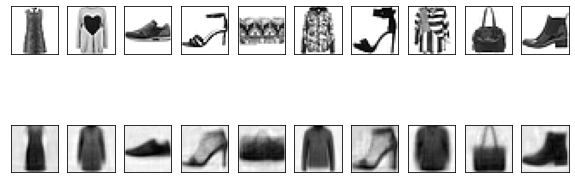

Train_Epoch : 19, [0 / 60000](0%)	Train_loss : 0.022155
Train_Epoch : 19, [12800 / 60000](21%)	Train_loss : 0.025607
Train_Epoch : 19, [25600 / 60000](43%)	Train_loss : 0.023755
Train_Epoch : 19, [38400 / 60000](64%)	Train_loss : 0.021359
Train_Epoch : 19, [51200 / 60000](85%)	Train_loss : 0.022969

EPOCH : 19, Test_loss 0.000003



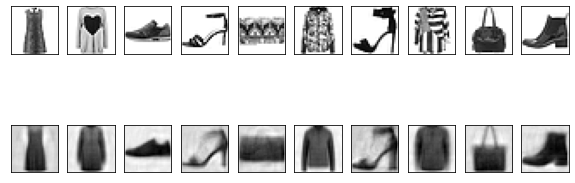

Train_Epoch : 20, [0 / 60000](0%)	Train_loss : 0.023530
Train_Epoch : 20, [12800 / 60000](21%)	Train_loss : 0.024866
Train_Epoch : 20, [25600 / 60000](43%)	Train_loss : 0.024721
Train_Epoch : 20, [38400 / 60000](64%)	Train_loss : 0.021171
Train_Epoch : 20, [51200 / 60000](85%)	Train_loss : 0.020828

EPOCH : 20, Test_loss 0.000003



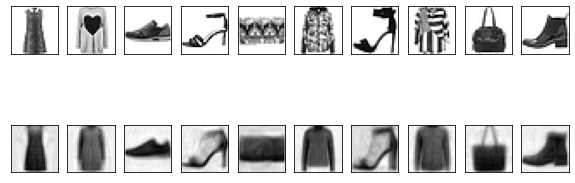

Train_Epoch : 21, [0 / 60000](0%)	Train_loss : 0.022191
Train_Epoch : 21, [12800 / 60000](21%)	Train_loss : 0.023156
Train_Epoch : 21, [25600 / 60000](43%)	Train_loss : 0.021442
Train_Epoch : 21, [38400 / 60000](64%)	Train_loss : 0.024304
Train_Epoch : 21, [51200 / 60000](85%)	Train_loss : 0.021211

EPOCH : 21, Test_loss 0.000003



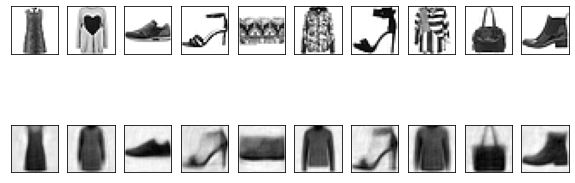

2.820741757750511e-06


In [96]:
import sys
min_loss = sys.maxsize
es = 0

for Epoch in range(1, EPOCHS + 1) :
    train(model, train_loader, optimizer)
    test_loss, encoded_list, decoded_list = evlauate(model, test_loader)
    print('\nEPOCH : {}, Test_loss {:.6f}\n'.format(
        Epoch, test_loss
    ))
    f, a = plt.subplots(2, 10, figsize = (10, 4))
    for i in range(10) :
        img = np.reshape(encoded_list[0][i], (28, 28))
        a[0][i].imshow(img, cmap = 'gray_r')
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())
    
    for i in range(10) :
        img = np.reshape(decoded_list[0][i], (28, 28))
        a[1][i].imshow(img, cmap = 'gray_r')
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())
    plt.show()

    if test_loss < min_loss :
        min_loss = test_loss
        best_model = model
        es = 0
    else :
        es += 1

    if es >= 10 :
        print(min_loss)
        break